In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print(sns.__version__)
import os 
from datetime import datetime

In [ ]:
basedirectory = os.getcwd()
os.chdir(r"C:\Users\ivann\OneDrive\Documents\~General Assembly Documents")


In [ ]:
raw_data = pd.read_csv("DSI_kickstarterscrape_dataset.csv", encoding ="latin-1")

In [ ]:
raw_data.head()
#two things you shoul always do, dataset.info() and dataset.describe()

In [ ]:
display(raw_data.info())
display(raw_data.describe())

In [ ]:
#Let's update the data types on our raw data
data_updated_dtype = raw_data

In [ ]:
#changing the project id from an integer to a string
data_updated_dtype['project id'] = data_updated_dtype['project id'].astype('string')


#let's put the day of the week into it's own column
data_updated_dtype[['Day of Week','funded date']] = data_updated_dtype['funded date'].str.split(',',n=1,expand=True)
#let's remove the annoying zeros at the end of the each entry
data_updated_dtype['funded date']= data_updated_dtype['funded date'].str.rstrip('-0000')
data_updated_dtype['Funded Date'] = pd.to_datetime(data_updated_dtype['funded date']).dt.date
data_updated_dtype['Funded Time'] = pd.to_datetime(data_updated_dtype['funded date']).dt.time
data_updated_dtype.head()

In [ ]:
data_updated_dtype.describe()

In [ ]:
#Now let's drop the original date time column
data_updated_dtype.drop(columns = ['funded date'], inplace = True)
data_updated_dtype.head()

In [ ]:
data_updated_dtype.head()

In [ ]:
#Let's check to see what type of data we have
data_updated_dtype.info()

In [ ]:
data_updated_dtype.isna().any() #let's check for missing values in our updated dtype data set
#Expected output: 
# project id           False
# name                 False
# url                  False
# category             False
# subcategory          False
# location              True
# status               False
# goal                 False
# pledged               True
# funded percentage    False
# backers              False
# levels               False
# reward levels         True
# updates              False
# comments             False
# duration             False
# Day of Week          False
# Funded Date          False
# Funded Time          False
# dtype: bool

In [ ]:
#rename two word columns to be correct
data_updated_dtype["reward_levels"]=data_updated_dtype['reward levels']


In [ ]:
#remove old reward levels column
data_updated_dtype.drop(columns=['reward levels'],inplace=True, axis=1)
data_updated_dtype.head()

In [ ]:
#calling the number of null values in a specific column
pledged_null = data_updated_dtype.isnull().pledged.sum()
location_null = data_updated_dtype.isnull().location.sum()
reward_null = data_updated_dtype.isnull().reward_levels.sum()
print("null location count", location_null)
print("pledged null", pledged_null)  
print ("reward levels null", reward_null)

In [ ]:
#Let's drop any rows that are missing locations, since we have no way to determine what the Location should be from the data we have.
data_updated_dtype.dropna(subset=['location'],inplace=True)

#let's double check that we removed all the null values
location_null = data_updated_dtype.isnull().location.sum()
print("null location count", location_null)

In [ ]:
#let's drop the rows missing reward levels since we have no way to calculate this as well.
data_updated_dtype.dropna(subset=['reward_levels'],inplace=True)

#let's double check that we removed all the null values
reward_null = data_updated_dtype.isnull().reward_levels.sum()
print ("reward levels null", reward_null)

In [ ]:
#We will now attempt to update the null pldeged values using Goal amount and funded percentage
#call all rows that do not contain a pledged amount
#Let's calculate a new column called "Calculted_Pledged" and compare that with the reported pldege amounts to see if they are 
#the same.
data_updated_dtype['Calculated_Pledged']=round(data_updated_dtype['goal']*(data_updated_dtype['funded percentage']),0)
data_updated_dtype['pledgedMatch?'] = np.where(data_updated_dtype['pledged'] == data_updated_dtype['Calculated_Pledged'], 'True', 'False')  
#create new column in df1 to check if pledged amounts  match

data_updated_dtype.sample(100)


In [ ]:
#Let's add in the pldged amount where appropiate in our dataset
nullpledged_df = data_updated_dtype[data_updated_dtype.isnull().pledged]
nullpledged_df.head(20) #there should only be 12 rows in the pledged null data frame
# data_updated_dtype['pledged']=round(nullpledged_df['goal']*(nullpledged_df['funded percentage']),0)
# pledged_null = data_updated_dtype.isnull().pledged.sum()
# print("pledged null", pledged_null)  



In [ ]:
#Let's attempt to fill in the values for this temporary data frame
#the following code snippet was me testing how to use the np.where function, which essentialy acts like an if-then function.
#The function worked the way that I hoped it would
# nullpledged_df['pledged'] = np.where(nullpledged_df['pledged'].isnull(),round(nullpledged_df['goal']*(nullpledged_df['funded percentage']),0),nullpledged_df['pledged'])
# nullpledged_df.head(12)


In [ ]:
#Use the numpy "where" function to replace NAN values in the data set with by calculating pledged amount from fundraising goal * pledged percentage.
data_updated_dtype['pledged'] = np.where(data_updated_dtype['pledged'].isnull(),round(data_updated_dtype['goal']*(data_updated_dtype['funded percentage']),0),data_updated_dtype['pledged'])
pledged_null = data_updated_dtype.isnull().pledged.sum()
#the expected output is 0. 
print("pledged null", pledged_null) 

In [ ]:
#create a new dataset to be used for further data cleaning
#We need to drop the extra columns we created, i.e. pledgedmatch? and calculated pledge
data_updated_dtype.drop(columns= ['Calculated_Pledged','pledgedMatch?'], inplace=True)
no_nulls_data= data_updated_dtype
no_nulls_data.head()



In [ ]:
#Next Step: Let's make sure all categories are unique and consistent
print(no_nulls_data.category.unique())
print(no_nulls_data.groupby(['category'])['category'].count())
#From our output, we see that Film & Video is written two ways, Film & Video + Film &amp; Video
#The total expected amount of listings that fall in the Film & video category is 13,082
#Expected output
# category
    # Art                  3872
    # Comics               1034
    # Dance                 744
    # Design               1738
    # Fashion              1117
    # Film & Video          482
    # Film &amp; Video    12600
    # Food                 1411
    # Games                1689
    # Music               10671
    # Photography          1424
    # Publishing           4585
    # Technology            774
    # Theater              2451

In [ ]:
#Relace all instances of Film &amp; Video with Film & Video
no_nulls_data['category'] = np.where(no_nulls_data['category'] =='Film &amp; Video','Film & Video',no_nulls_data['category'])
print(no_nulls_data.groupby(['category'])['category'])


In [ ]:
#let's identify the unique values of our subcategories
# print(no_nulls_data.subcategory.unique())
print(no_nulls_data.groupby(['subcategory'])['subcategory'].count())
# print(no_nulls_data.loc[no_nulls_data['subcategory'] == 'Board & Card Games'].count())


In [ ]:
#Let's redefine Board &amp; Card Games,  Country &amp; Folk  ,  Film &amp; Video
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Film &amp; Video','Film & Video',no_nulls_data['subcategory'])
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Country &amp; Folk','Country & Folk',no_nulls_data['subcategory'])
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Board &amp; Card Games','Board & Card Games',no_nulls_data['subcategory'])

# for item  in no_nulls_data['subcategory']:
#     if (item == 'Film &amp; Video'):
#         no_nulls_data['subcategory'][item]= ('Film & Video')
#     else:
#         item = item
    
# no_nulls_data.shape
#In order to iterate over an index I need to reindex my code.
no_nulls_data.reset_index(drop=True, inplace= True)
no_nulls_data.head(20)
# print(no_nulls_data['subcategory'][0]);
# print(no_nulls_data['subcategory'][11]);
# i = 0;
# for i in range(len(no_nulls_data['subcategory'])):
# #     print(no_nulls_data['category'][i])
#     if no_nulls_data['subcategory'][i] == 'Film &amp; Video':
#         no_nulls_data['subcategory'][i] ="Film & Video"
#     elif no_nulls_data['subcategory'][i] == 'Board &amp; Card Games':
#         no_nulls_data['subcategory'][i] = "Board & Card Games"
#     elif no_nulls_data['subcategory'][i] == 'Country &amp; Folk':
#         no_nulls_data['subcategory'][i] ="Country & Folk"
# no_nulls_data.column = df.column.apply(<urstuff>)
    
        
        
#     if no_nulls_data['subcategory'][i] == 'Film &amp; Video':
#         no_nulls_data['subcategory'][i] = "Film & video"
#     else:
#         no_nulls_data['subcategory'][i] = no_nulls_data['subcategory'][i]
# no_nulls_data.head(20)
#Print statement to make sure everything was renamed properly
#print(no_nulls_data.subcategory.unique())
no_nulls_data.head()




In [ ]:
#Let's remove extra columns if possible
# print(no_nulls_data['pledgedMatch?'].is())
# print(no_nulls_data['goal'].count())

In [ ]:
#Rename no_null_data to the final dataset since everything is finally cleaned
#Convert the the decimal repesentation of funded percentage to actually correspond with the percentage
no_nulls_data['funded percentage']= no_nulls_data['funded percentage'].apply(lambda x: x*100)
final_data=no_nulls_data

In [ ]:
#Let's describe our data set 
round(final_data.describe(),2)
#             goal   	pledged  	funded percentage	backers 	levels  	updates 	comments	duration
# count	4.459200e+04	4.459200e+04	44592.000	44592.000  	44592.000	44592.000	44592.000	44592.000
# mean	1.210894e+04	5.104144e+03	165.889 	71.038  	8.047	4.069	8.526	39.628
# std	1.916062e+05	5.769624e+04	7634.553	698.999  	4.247	6.404	176.651	17.087
# min	5.000000e-01	0.000000e+00	0.000   	0.000   	1.000	0.000	0.000	1.000
# 25%	1.800000e+03	2.000000e+02	4.500   	5.000   	5.000	0.000	0.000	30.000
# 50%	4.000000e+03	1.326000e+03	100.000 	23.000  	8.000	2.000	0.000	31.605
# 75%	1.000000e+04	4.205000e+03	111.667 	60.000  	10.000	6.000	3.000	47.020
# max	2.147484e+07	1.026684e+07	1506600.000	87142.000	80.000	149.000	19311.000	91.960

In [ ]:
#Let's start plotting our data to understand what is going on!

#Let's try some basic analysis, how do # of updates affect funding percentage. Let's color code it by category for fun
print("Percentage of campaigns with no updates" + ' '+ 
      str(round(final_data.loc[final_data['updates'] ==0, ['updates']].count()[0] 
        #this counts all the situations where updates are = 0, #the [0] at the end is because the original output is a 1x1 array and I only need a single value
      /final_data.updates.count(),2)))
sns.histplot(final_data["updates"], binrange= [0, 40])
#Turns out that a vast majority of the 

In [ ]:
#Lets look at a histogram for each coloumn shall we
print(final_data.groupby(['goal']).goal.count())
# sns.histplot(final_data["goal"])


In [ ]:
figsize = (15,10)
sns.histplot(data=final_data,x = 'pledged', binrange= [0, 10000], hue= 'category')


In [ ]:
#Let's do histogram plots for every quant column
#Let's map out the histogram for all the categories and what they raised
num_catergories= final_data.category.nunique()
# print(num_catergories)
category_list = final_data.category.unique() #list of categories
fig, axs = plt.subplots(7,2,figsize= (15,25))
fig.suptitle('Histograms of $ Goal Amount')

row_counter = 0
col_counter = 0
#figure out why your key for Film& Video isn't working!
# print(final_data.loc[final_data['category']== 'Games',['goal']])


#This cell plots all the histograms of all the different categories. We can now repeate this process for any other metric we are interested in

for index in category_list:
    sns.histplot(final_data.loc[final_data['category']== index,['goal']], binrange= [0, 10000], ax= axs[row_counter,col_counter], legend=False)
    axs[row_counter,col_counter].set_title(index)
    col_counter += 1
    
    if col_counter == 2:
        col_counter = 0
        if row_counter <= 5:
            row_counter +=1
    




In [ ]:
category_list = final_data.category.unique() #list of categories
#After looking at some initial plotting, I realized that sharing the y-axis would be a bad idea
fig, axs = plt.subplots(7,2,figsize= (15,25))
fig.suptitle('Histograms of $ Pledged')
row_counter = 0
col_counter = 0


for index in category_list:
    sns.histplot(final_data.loc[final_data['category']== index,['pledged']],bins= 20, ax= axs[row_counter,col_counter], binrange= [0, 5000],legend=False, stat='probability')
    axs[row_counter,col_counter].set_title(index)
    col_counter += 1
    
    if col_counter == 2:
        col_counter = 0
        if row_counter <= 5:
            row_counter +=1
            
# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
#Let's create overlapping histograms of amount pledged vs. amount raised. Maybe a scatter plot would be better?
# fig = plt.gcf()

# Change seaborn plot size
# fig.set_size_inches(20, 20)
# fig, axs = plt.subplots(1,5,figsize= (15,25))
plt.clf()
# ongoing_data = 
sns.relplot(x= 'goal', y='pledged', hue='category', data= final_data, height = 20)
# control x and y limits
plt.ylim(0, 100000)
plt.xlim(0, 100000)



In [ ]:
#Let's look at which category was the most sucessful

plt.figure(figsize=(20,10))
ax = sns.countplot(x="status", hue="category", data=final_data)
plt.legend(loc='upper right')

In [ ]:
# sns.histplot(final_data['goal'])

In [ ]:
print(final_data['goal'].describe())

In [ ]:
# quartile_range= (final_data['goal'].percentile(75) - final_data['goal'].percentile(75))
iq_range= np.percentile(final_data['goal'],75) - np.percentile(final_data['goal'],25)
outlier_limit = 1.5*iq_range +np.percentile(final_data['goal'],75)
print(outlier_limit)
# print(quartile_range)

In [ ]:
num_outliers = len(final_data.loc[final_data['goal'] > outlier_limit])
num_of_projects = len(final_data['goal'])

percent_outliers = (num_outliers/num_of_projects)* 100
print("Percent of Data being Outliers")
print(percent_outliers)


In [ ]:
num_success_outliers = len(final_data.loc[(final_data['goal'] > outlier_limit) & (final_data['status'] == "successful")])
percent_success_outliers = (num_success_outliers/num_outliers)*100
print(percent_success_outliers)

In [ ]:
# plt.clf()
# sns.histplot(final_data, x= 'goal', stat="count", binwidth = '1000')


In [ ]:
plt.clf()
plt.figure(figsize=(15,10))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [0,10000])


In [ ]:
plt.clf()
plt.figure(figsize=(15,15))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [0,outlier_limit])


In [ ]:
plt.clf()
plt.figure(figsize=(10,10))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [10000,200000])

In [ ]:
plt.clf()
plt.figure(figsize=(10,10))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [200000,1000000])

In [ ]:
plt.clf()
plt.figure(figsize=(15,10))
ax= sns.ecdfplot(final_data, x= 'goal', stat="count")

In [ ]:
#We will use this dataframe as the input for our logistic regression model
#no_outlier_regression_data = nord
nord = final_data.loc[final_data['goal'] < outlier_limit]
nord = nord[(nord['status']== 'successful')|(nord['status']=='failed')]
nord.head()


In [ ]:
j = sns.jointplot(data=nord[nord.subcategory == 'Animation'], x='goal',y='pledged', color='Green', kind = "hex")


In [ ]:
g2 = sns.FacetGrid(nord, row='subcategory', col='status' ,hue='subcategory', sharey= False, height= 4)
# g2.figure(figsize(20,20)) 
g2= g2.map(plt.scatter, 'goal' , 'pledged')
g2.set(xlim=(0,10000), ylim=(1,10000)) #ths sets the graph boundaries

for ax in g2.axes.flat:
    ax.plot((0,10000),(0,10000),c='gray', ls="--")
g2.add_legend()

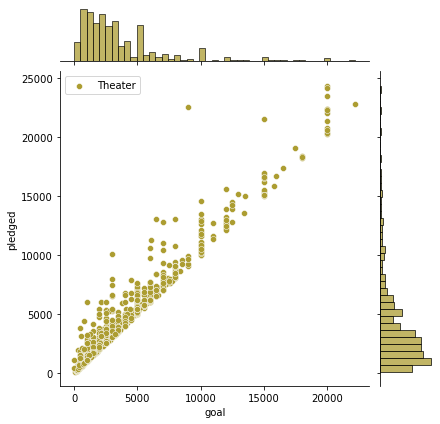

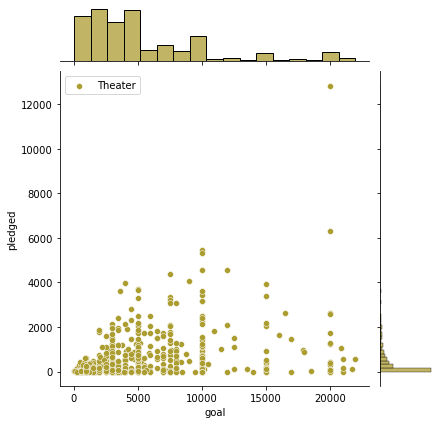

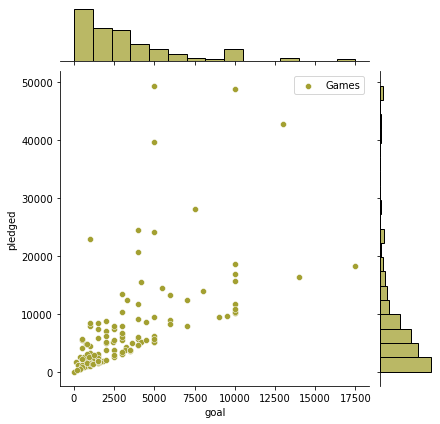

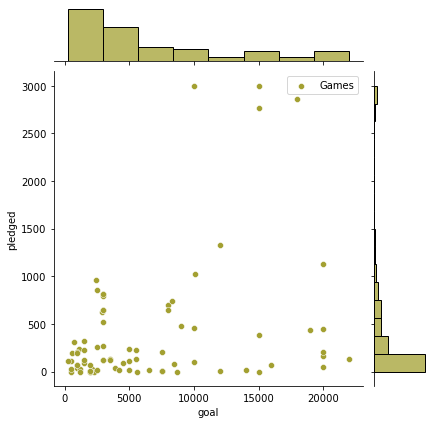

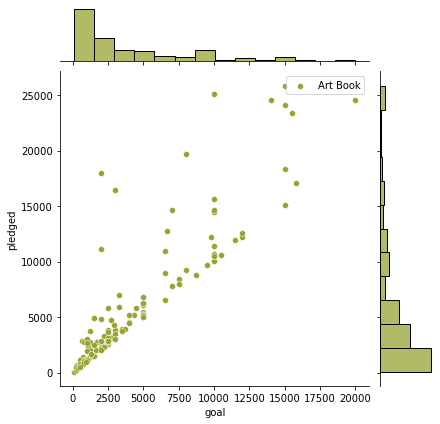

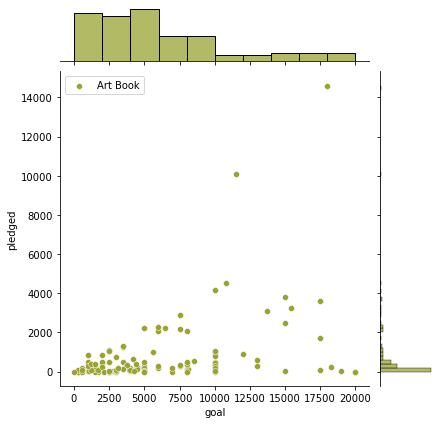

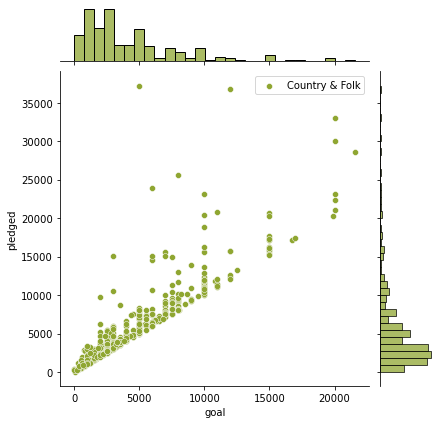

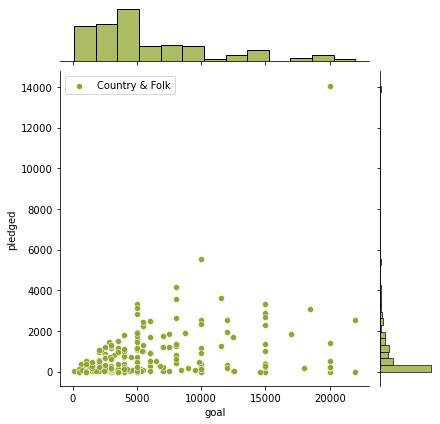

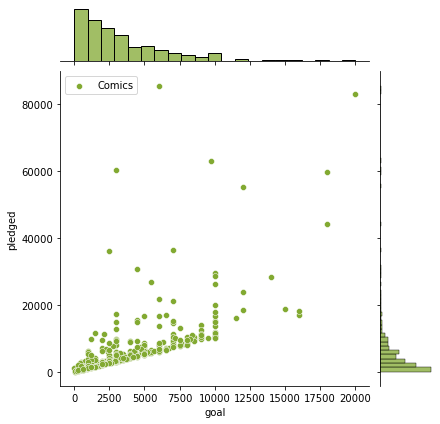

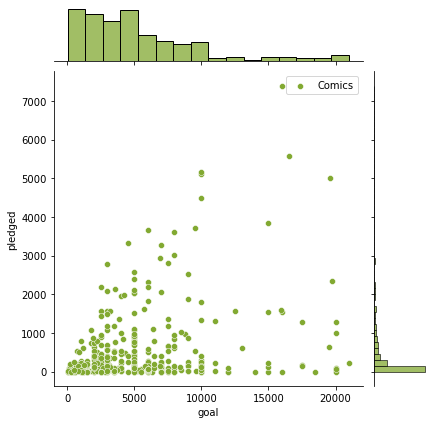

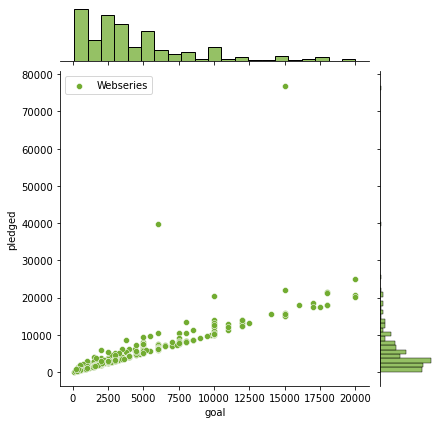

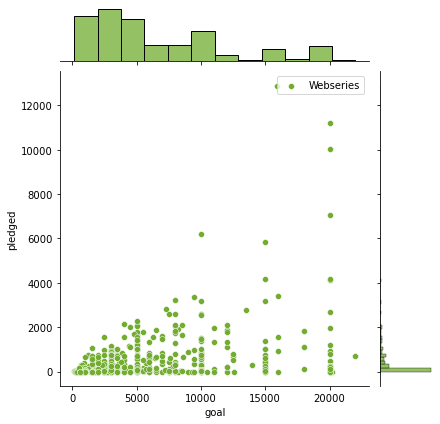

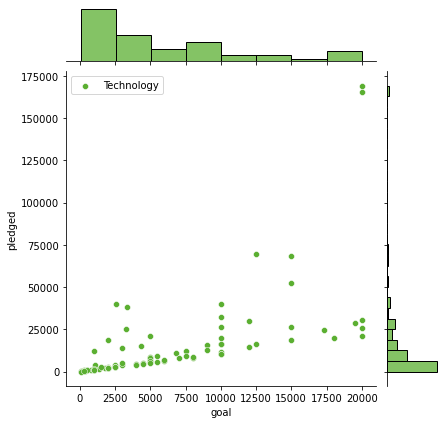

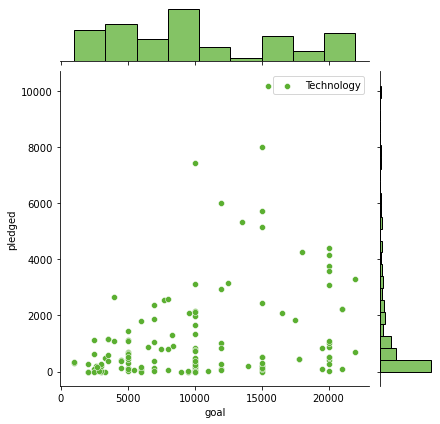

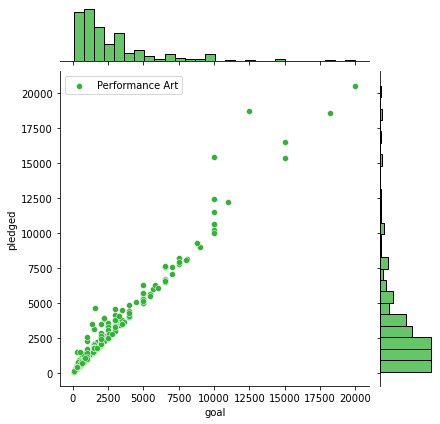

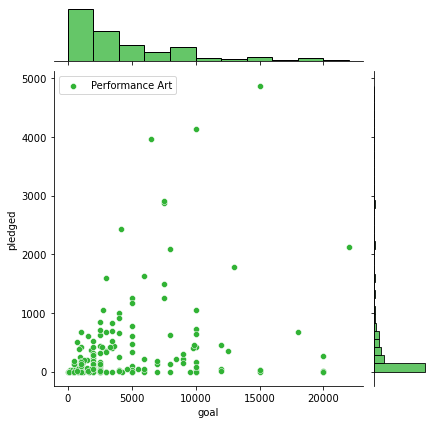

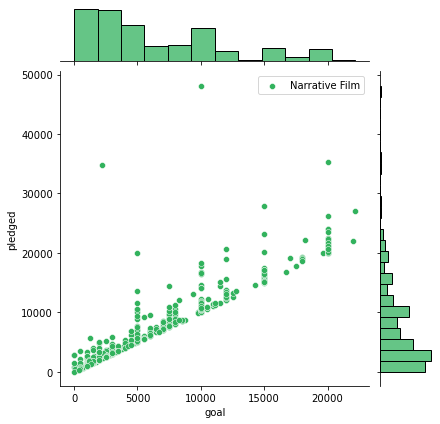

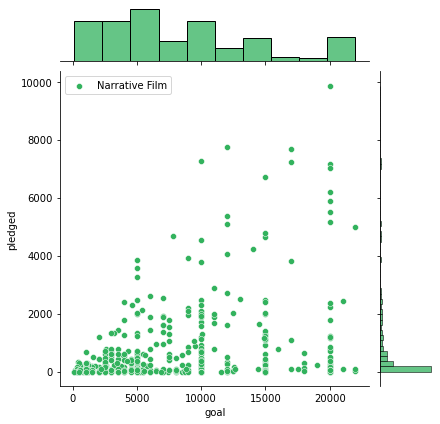

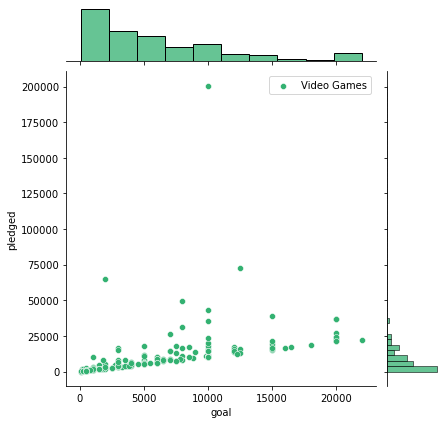

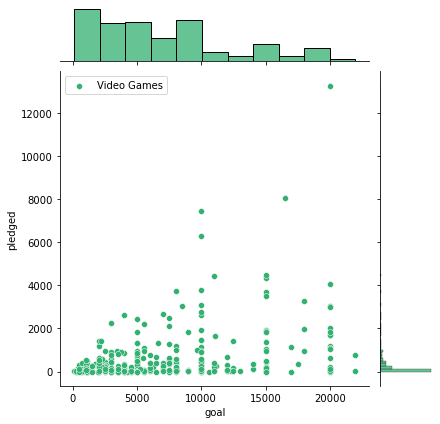

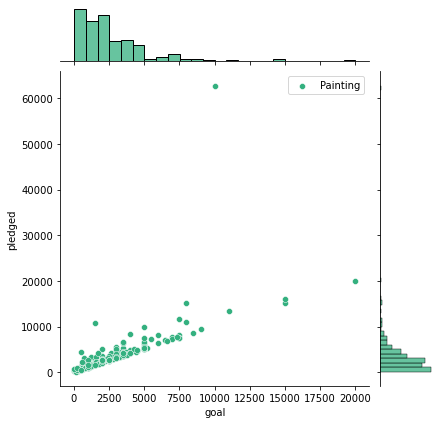

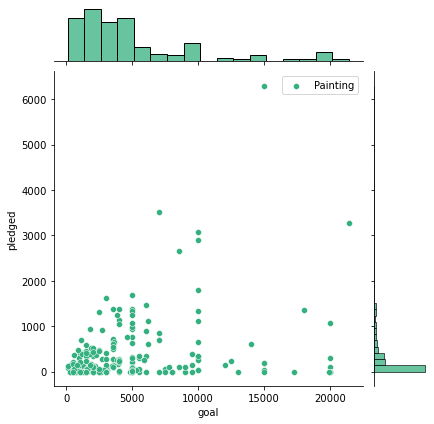

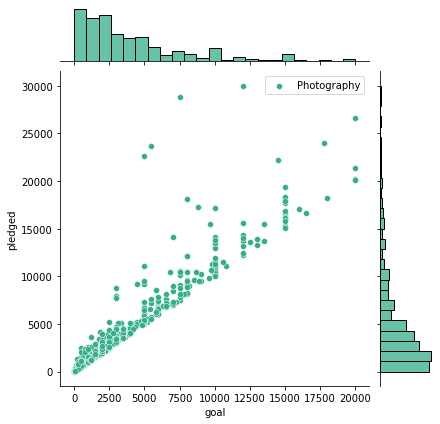

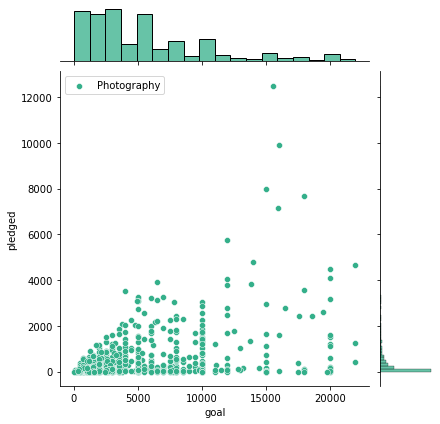

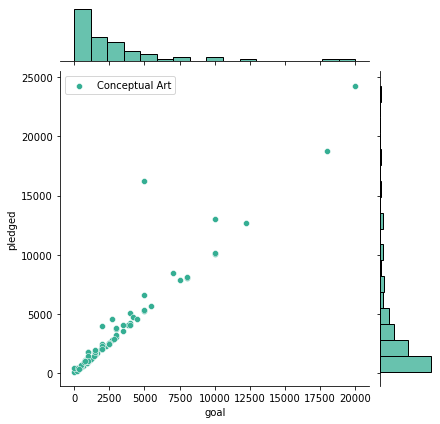

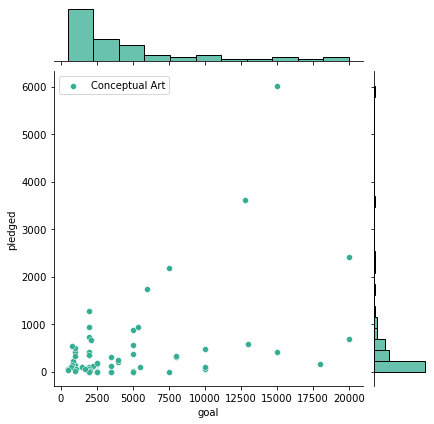

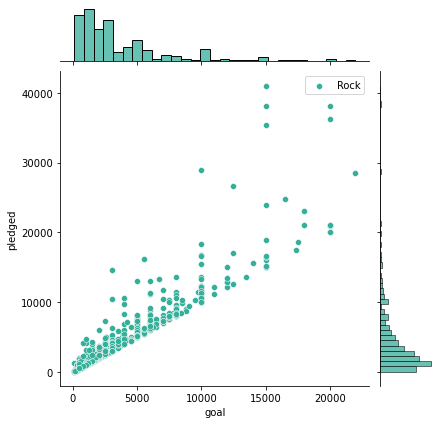

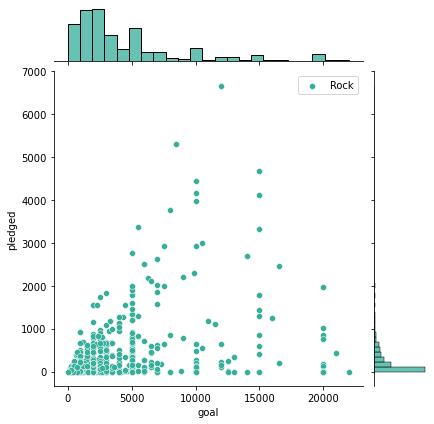

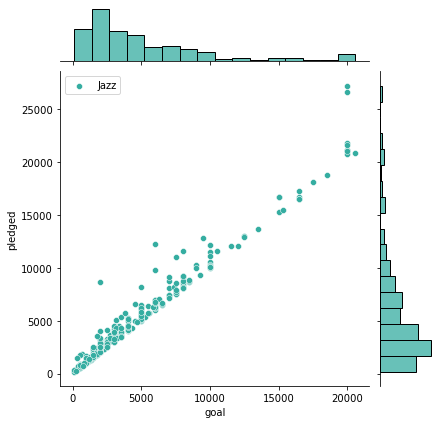

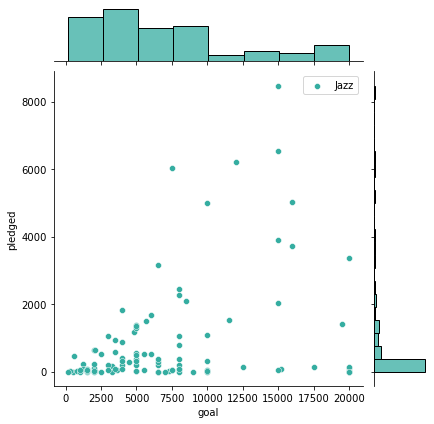

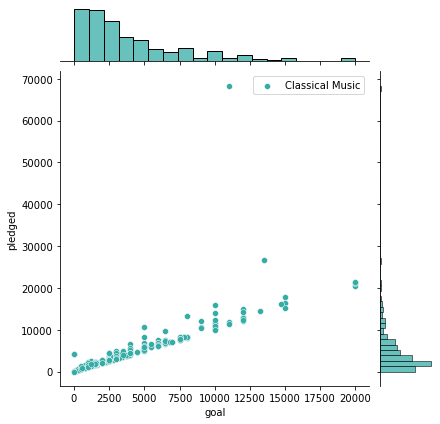

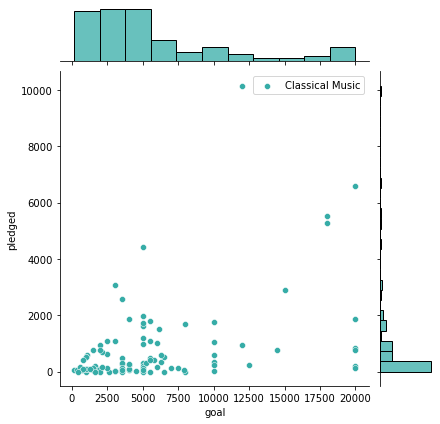

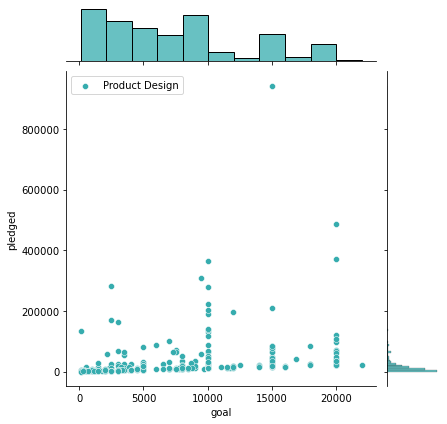

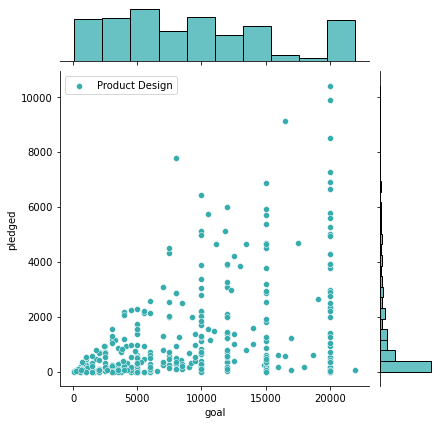

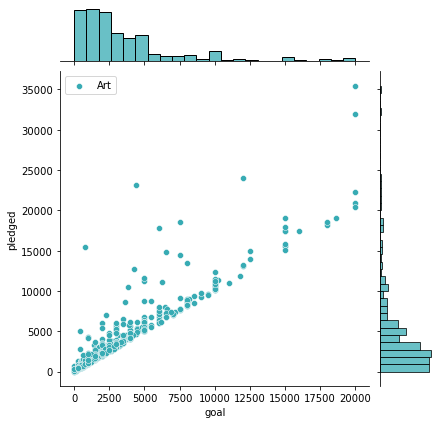

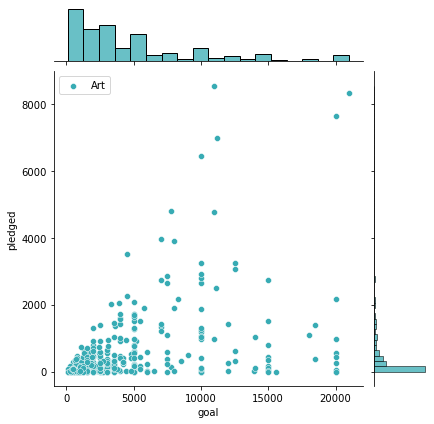

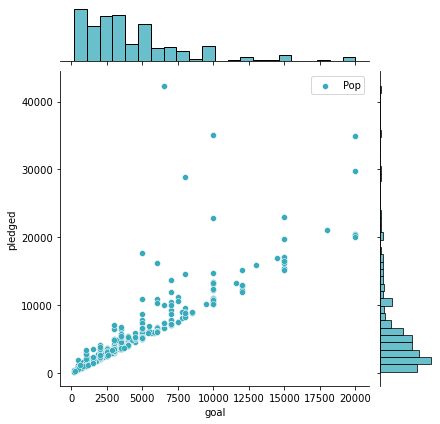

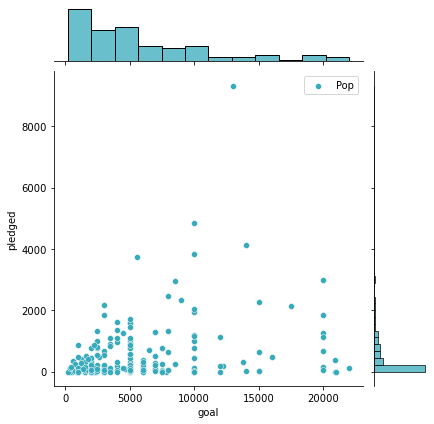

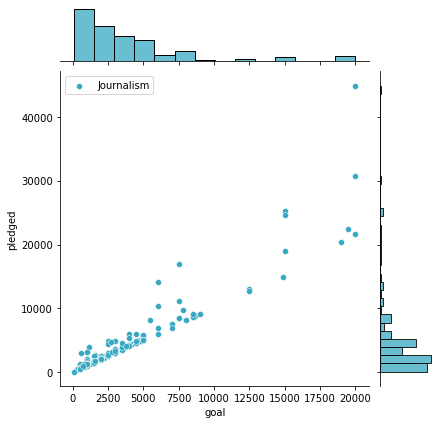

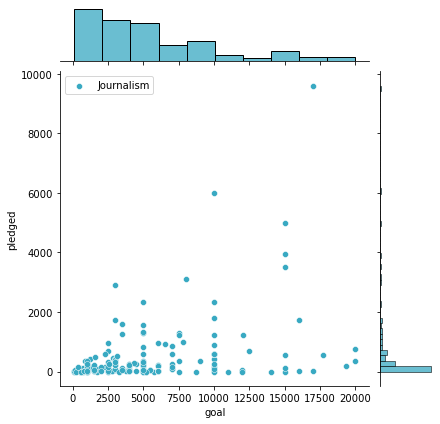

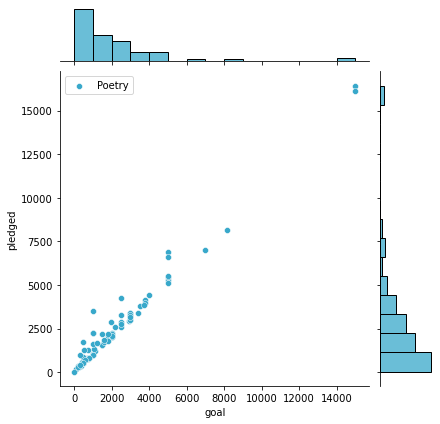

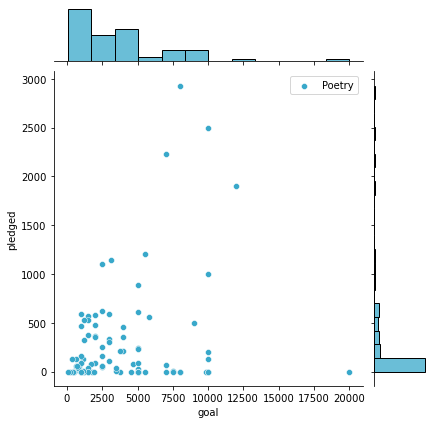

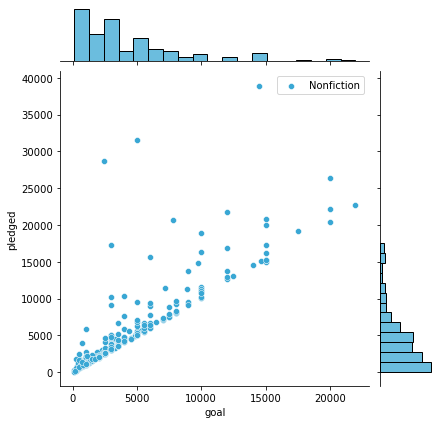

In [75]:
plt.clf()
g3 = sns.FacetGrid(nord, row='subcategory' ,hue='subcategory', height= 6)
# g2.figure(figsize(20,20)) 
g3= g2.map(sns.jointplot, 'goal' , 'pledged')